# Get petioles

The petiole is the part that connects the leaf to the main stem. This notebook attempts to segment out leaves while keeping the petiole intact.

Based on previous discussions, I assume that the pots will be transparent or below the level of the plant, and the leaves will not go outside of the pot. Therefore I do not attempt to address these problems in this notebook.

To obtain the .tif file used in this notebook from a stack of scans, enter the command

python3 seqToStack.py Col-0_Y_Slices_day12/Col-0\ Y_*.tif col_0.tif

In [1]:
import os
import math
import importlib
import pandas as pd

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import scipy.ndimage as ndimage

import tifffile as tf

import arabidopsis_utils as thales

from PIL import Image, ImageDraw

from itertools import groupby

from skimage.morphology import convex_hull_image
from skimage import data, img_as_float
from skimage.util import invert

In [23]:
dst = '../petiole/'
tiff_file  = '../raw3d/col-0.tif'

In [5]:
_ , fname = os.path.split(tiff_file)
bname = os.path.splitext(fname)[0]
img = tf.imread(tiff_file)

## Separate pots

Since we are not thresholding out air or soil, we create a 2-d image by taking the maximum value of each 0th coordinate column. After the first cell, the strategy follows Erik's code

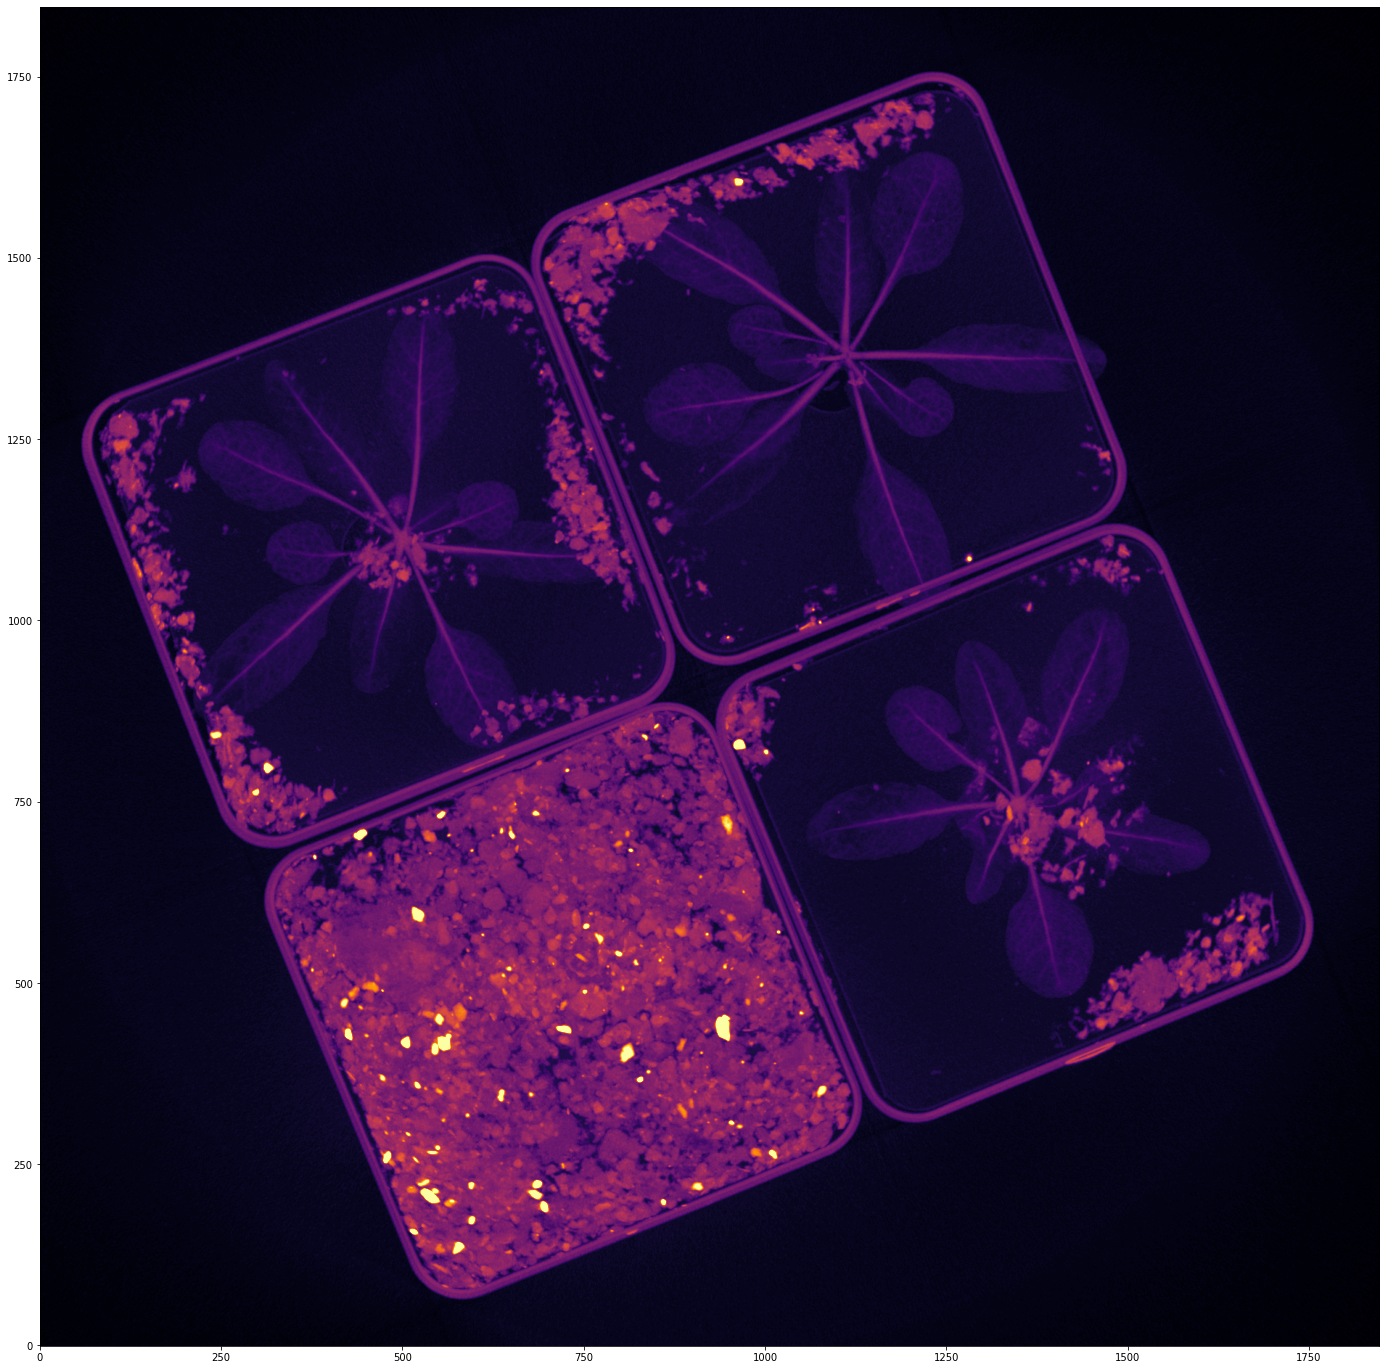

In [6]:
# 180:500 for col-0
# 210:500 for u112-3
max_image = np.max(img[180:500], axis = 0)

fig, ax = plt.subplots(figsize = (24,36))
im = ax.imshow(max_image, cmap='inferno', origin='lower', vmax =75)

plt.show()

In [7]:
pts = max_image.astype(np.uint8)

In [8]:
# be aggressive here, choice is only to get pot outline for bounding box.
pts[pts < 30] = 0 # 30 for col-0 35 for u112-3
pts[pts > 0] = 1
border = np.array([[-1, -1, -1],
                   [-1, 8, -1],
                   [-1, -1, -1]])

surface = ndimage.convolve(pts, border, np.int8, 'constant', cval=0)
surface[ surface < 0 ] = 0
surface = surface.astype(np.uint8)
surface[ surface > 0 ] = 1

In [7]:
# fig, ax = plt.subplots(figsize = (24,36))
# im = ax.imshow(pts, cmap='inferno', origin='lower')

# plt.show()

In [9]:
# get bounding box of all 4 plants
corners = thales.four_corners(pts)
tpt, rpt, bpt, lpt = corners
center = np.mean(corners,axis=0)

rhull = np.vstack((lpt,tpt,rpt,bpt,lpt))

In [9]:
# plt.figure(figsize=(10,10))
# plt.imshow(surface, cmap='inferno', origin='lower');
# plt.plot(rhull[:,1], rhull[:,0], 'y--', lw=3);

In [10]:
# get coordinates midpoints, centers (shown below)
bcoefs = thales.four_borderlines(corners)
midpoints = thales.four_midpoints(corners)
mcoefs = thales.midline_splits(midpoints)
centers = thales.four_centers(corners, midpoints)

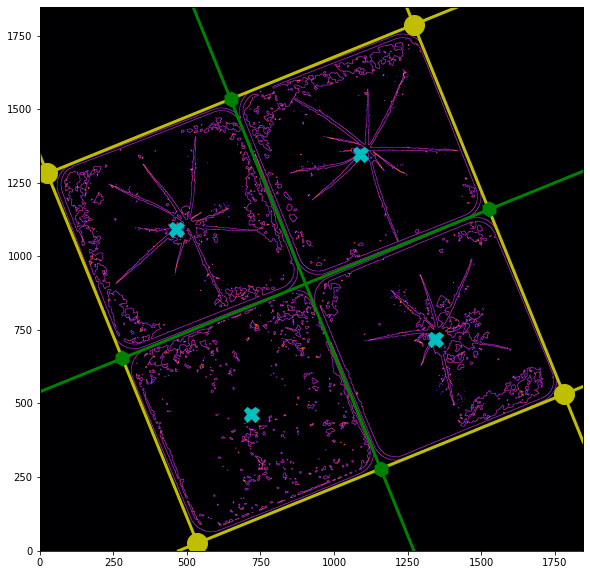

In [11]:
plt.figure(figsize=(10,10))
plt.imshow(surface, cmap='inferno', origin='lower');
for i in range(len(bcoefs)):
    plt.axline(corners[i,:][::-1], slope=bcoefs[i,1], c='y', lw=3)
    plt.plot(corners[i,1], corners[i,0], 'yo', ms=20)
    plt.plot(centers[i,1], centers[i,0], 'cX', ms=15)
    plt.plot(midpoints[i,1], midpoints[i,0], 'gh', ms=15)
for i in range(len(mcoefs)):
    plt.axline(midpoints[i,:][::-1], slope=mcoefs[i,1], c='g', lw=3)

#plt.plot(center[1], center[0], 'mD', ms=15);
#plt.tight_layout()

#filename = dst + bname + '_split_pots.jpg'
#plt.savefig(filename, dpi=96, pil_kwargs={'optimize':True})

For each pot, create a mask that will show only that pot. Each pot is drawn clockwise, starting from top.

In [12]:
# need to flip these around to draw the polygon
midpoints_reverse = midpoints.astype(int)
midpoints_reverse = midpoints_reverse[:,[1,0]]

In [13]:
center_reverse = center.astype(int)
center_reverse = center_reverse[[1,0]]

In [14]:
corners_reverse = corners.astype(int)
corners_reverse = corners_reverse[:,[1,0]]

In [15]:
width = img.shape[1]
height = img.shape[2]

In [16]:
mask = {}

In [17]:
# draw each pot, based on the four corners, going clockwise
polygon0 = [tuple(corners_reverse[0]),tuple(midpoints_reverse[0]),tuple(center_reverse),tuple(midpoints_reverse[3])]

img0 = Image.new('L', (width, height), 0)
ImageDraw.Draw(img0).polygon(polygon0, outline=1, fill=1)
mask[0] = np.array(img0)

In [18]:
polygon1 = [tuple(midpoints_reverse[0]),tuple(corners_reverse[1]),tuple(midpoints_reverse[1]),tuple(center_reverse)]

img1 = Image.new('L', (width, height), 0)
ImageDraw.Draw(img1).polygon(polygon1, outline=1, fill=1)
mask[1] = np.array(img1)

In [19]:
polygon2 = [tuple(center_reverse),tuple(midpoints_reverse[1]),tuple(corners_reverse[2]),tuple(midpoints_reverse[2])]

img2 = Image.new('L', (width, height), 0)
ImageDraw.Draw(img2).polygon(polygon2, outline=1, fill=1)
mask[2] = np.array(img2)

In [20]:
polygon3 = [tuple(midpoints_reverse[3]),tuple(center_reverse),tuple(midpoints_reverse[2]),tuple(corners_reverse[3])]

img3 = Image.new('L', (width, height), 0)
ImageDraw.Draw(img3).polygon(polygon3, outline=1, fill=1)
mask[3] = np.array(img3)

An area of improvement would be to figure out a less repetetive way to code this (using a dictionary and/or for loop)

In [21]:
# isolate each pot, by multiplying all non-pot pixels by zero
pots = {}

for i in range(0, 4):
    pots[i] = np.multiply(mask[i],max_image)

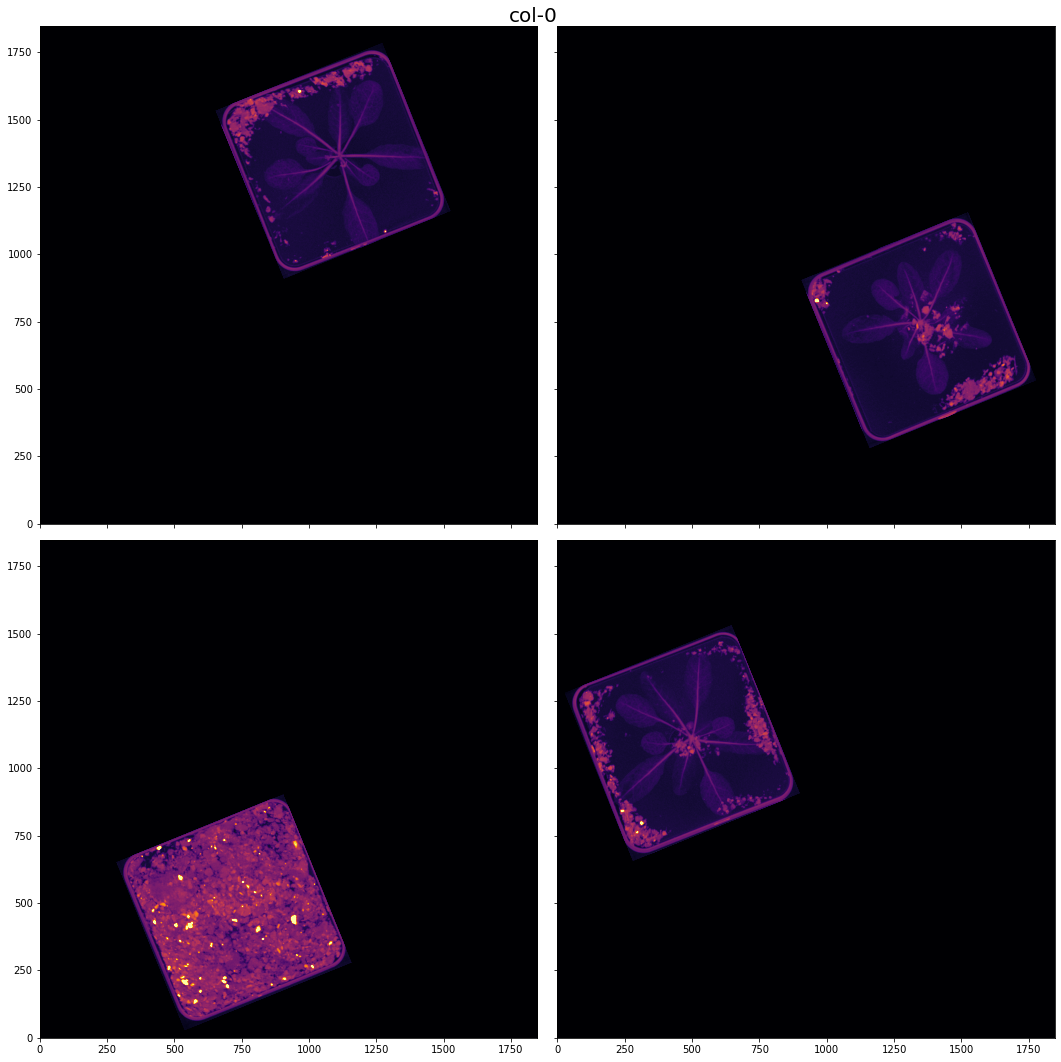

In [24]:
fig, ax = plt.subplots(2,2, figsize=(15,15), sharex=True, sharey= True)

ax[0,0].imshow(pots[0], cmap='inferno', origin='lower', vmin = 19, vmax = 75);
ax[0,1].imshow(pots[1], cmap='inferno', origin='lower', vmin = 19, vmax = 75);
ax[1,0].imshow(pots[2], cmap='inferno', origin='lower', vmin = 19, vmax = 75);
ax[1,1].imshow(pots[3], cmap='inferno', origin='lower', vmin = 19, vmax = 75);

fig.suptitle(bname, fontsize = 20)

fig.tight_layout()
filename = dst + bname +'petiole_separated_pots_4_binary.jpg'
plt.savefig(filename, dpi=96, format='jpg', pil_kwargs={'optimize':True}, bbox_inches='tight')

# Get conical volume of "allowed" voxels

Now we create a second mask for each pot. The idea here is that an arabidopsis plant is roughly conical (albeit a very flat cone), so if all voxels outside the cone are zero, that will take away most of the air and soil.

### Now get conical mask for each pot

In [23]:
# crop each pot, and get new centers

In [25]:
# get stack of slices, but only show one pot
# assume 500 layers is an upper bound for all pots

pot_stacks = {}

for i in range(0, 4):
    pot_stacks[i] = img[0:500]*mask[i]

In [26]:
# cut out most of the black area, make image quicker to work with

for i in range(0, 4):
    pot_stacks[i] = thales.clean_zeroes(pot_stacks[i])[0]

77 % reduction from input
77 % reduction from input
77 % reduction from input
77 % reduction from input


In [27]:
# to get new center of each pot, pick a random nonzero slice and use function from before
# the center of each plant is close enough to the center of the pot, so we will just center the cone there
def get_new_center(stack):
    pot_stack = stack[0]
    corners2 = thales.four_corners(pot_stack) # the 2 is just an artifact from function writing
    tpt, rpt, bpt, lpt = corners2
    center2 = np.mean(corners2,axis=0)
    center2_reverse = center2.astype(int)
    center2_reverse = center2_reverse[[1,0]]
    return center2_reverse

In [28]:
centers = {}

for i in range(0, 4):
    centers[i] = get_new_center(pot_stacks[i])

To determine where the bottom of the cone is, we look at a cylindrical tube through the center of the image (which approximates the center of the pot). The average intensity of each slice in the cylinder is computed, and we take the slice that occurs after the longest drop-off in intensity (intensity = dirt)

In [29]:
# https://stackoverflow.com/questions/44865023/how-can-i-create-a-circular-mask-for-a-numpy-array
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

In [30]:
# get a circular mask that just shows the small center circle. When there is a massive dropoff in intensity here,
# that is where the plant starts
circles = {}
for i in range(0, 4):
    circles[i] = create_circular_mask(pot_stacks[i][0].shape[0],pot_stacks[i][0].shape[1], centers[i], 50)

In [31]:
cylinders = {}
for i in range(0, 4):
    cylinders[i] = pot_stacks[i]*circles[i]

In [32]:
avgs = {}
for i in range(0,4):
    avgs[i] = np.mean(cylinders[i], axis=(1,2))

In [33]:
def find_sub_list(sl,l):
    sll=len(sl)
    for ind in (i for i,e in enumerate(l) if e==sl[0]):
        if l[ind:ind+sll]==sl:
            return ind,ind+sll-1

In [34]:
# compute the longest dropoff in intensity, then add a few slices for safe measure

dwcutoffs = {}

for i in range(0, 4):
    moving_average = [i for i in list(np.convolve(avgs[i], np.ones(10)/10, mode='valid'))]
    diffs = [j-i for i, j in zip(moving_average[:-1], moving_average[1:])]
    descending_lists = [k for g, k in ((i,list(j)) for i,j in (groupby(diffs, key=lambda x: x < 0))) if g == True and len(k) > 1]
    
    k = 0.0
    for j in descending_lists:
        if -sum(j)>k:
            k = -sum(j)
            descending_sublist = j
        else:
            pass
        
    dwcutoffs[i] = find_sub_list(descending_sublist, diffs)[1]+6

In [35]:
for i in range(0,4):
    pot_stacks[i] = pot_stacks[i][dwcutoffs[i]:]

In [36]:
# get cone of allowed pixels
# if radius is too small, plant leaves will get cut off. Think 3d
def get_conical_stack(pot_stack, center, radius_coeff):
    # make a copy so the input does not get changed (in case we want to change coefficient)
    pot_stack_copy = pot_stack.copy()
    
    # Multiply each layer of the pot stack by the conical mask
    for i in range(0, len(pot_stack)):
        circular_mask = create_circular_mask(pot_stack[0].shape[0],pot_stack[0].shape[1], center, radius_coeff*i)
        pot_stack_copy[i] = pot_stack[i]*circular_mask
        
    return pot_stack_copy   

In [37]:
# We compute two conical stack, one to capture the entire plant, and the other to capture only the petioles
# and midveins
pots_3d = {}
petioles_3d = {}

for i in range(0,4):
    conical_stack = get_conical_stack(pot_stacks[i], centers[i], 6)
    petiole_stack = conical_stack.copy()
    
    # get leaves+petioles
    conical_stack[conical_stack<24] = 0
    conical_stack[conical_stack>0] = 1
    
    # get just petioles/stems
    petiole_stack[petiole_stack<30] = 0
    petiole_stack[petiole_stack>0] = 1
    
    pots_3d[i] = conical_stack
    petioles_3d[i] = petiole_stack

# Isolate individual leaves
Look at the numpy array to find connected components in 3d

In [38]:
# changing this doesn't affect much, but it still may be worth experimenting with
structure = np.array([[[1,1,1],[1,1,1],[1,1,1]],[[1,1,1],[1,1,1],[1,1,1]],[[1,1,1],[1,1,1],[1,1,1]]])

In [39]:
def get_components(stack,n):

    # get a matrix labeled with the connected components of the input image
    labeled, ncomponents = ndimage.measurements.label(stack, structure)

    unique, counts = np.unique(labeled, return_counts=True)
    large_components = list(np.where(counts>500)[0])
    print("{} large components detected".format(len(large_components)-1))

    if n == 0:
        labels_dict = {}

    # optionally, separate the labeling matrix into one matrix per large connected component, with only the entries
    # of the indicated value
        for j in large_components:
            if j == 0:
                pass
            else:
                labeled2 = np.array(labeled == j, dtype = int)
                labels_dict[j] = np.delete(labeled2,np.where(~labeled2.any(axis=(1,2)))[0], axis=0)

        snaps = [thales.clean_zeroes(np.sum(labels_dict[j], axis = 0))[0] for j in labels_dict.keys()]
        return snaps
    else:
        return labeled

In [40]:
snaps = {}

for i in range(0,4):
    snaps[i] = get_components(pots_3d[i],0)

11 large components detected
94 % reduction from input
99 % reduction from input
98 % reduction from input
92 % reduction from input
99 % reduction from input
97 % reduction from input
96 % reduction from input
96 % reduction from input
95 % reduction from input
99 % reduction from input
99 % reduction from input
8 large components detected
99 % reduction from input
97 % reduction from input
95 % reduction from input
96 % reduction from input
97 % reduction from input
97 % reduction from input
96 % reduction from input
100 % reduction from input
9 large components detected
97 % reduction from input
100 % reduction from input
98 % reduction from input
95 % reduction from input
100 % reduction from input
94 % reduction from input
90 % reduction from input
99 % reduction from input
98 % reduction from input
10 large components detected
98 % reduction from input
93 % reduction from input
99 % reduction from input
99 % reduction from input
95 % reduction from input
95 % reduction from input

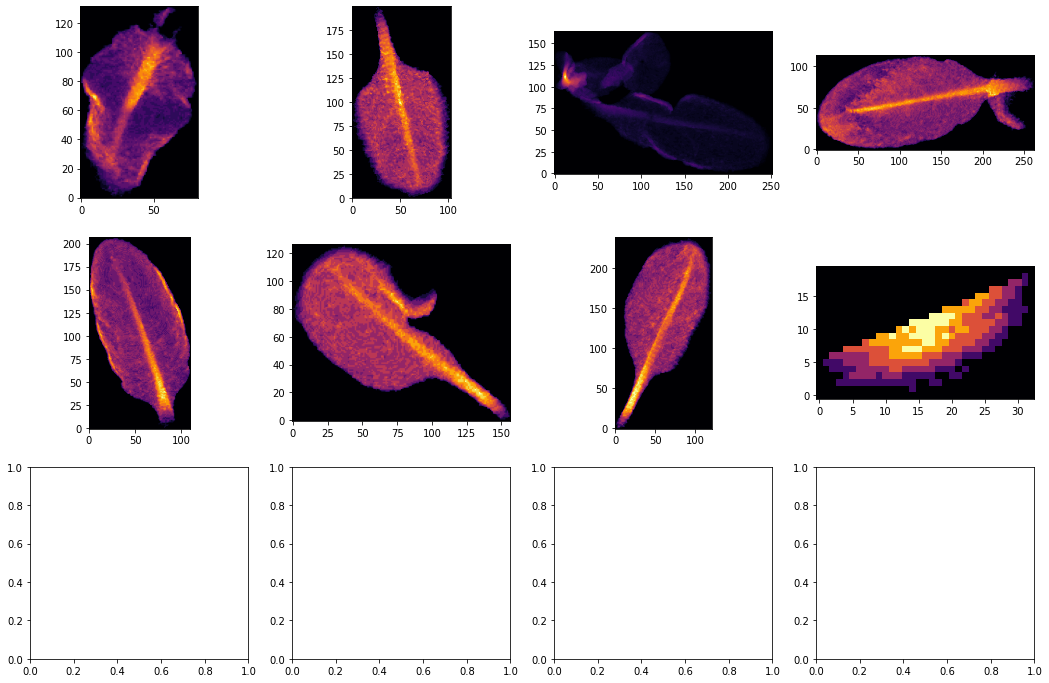

In [51]:
_, axs = plt.subplots(3, 4, figsize=(18, 12))
axs = axs.flatten()
for img, ax in zip(snaps[1], axs):
    ax.imshow(img, cmap='inferno', origin='lower')    

plt.show() 

# Watershed

In [41]:
# each petiole is a marker

In [46]:
markers_dict = {}

for i in range(0,4):
    markers_dict[i] = get_components(petioles_3d[i],1)

11 large components detected
10 large components detected
9 large components detected
10 large components detected


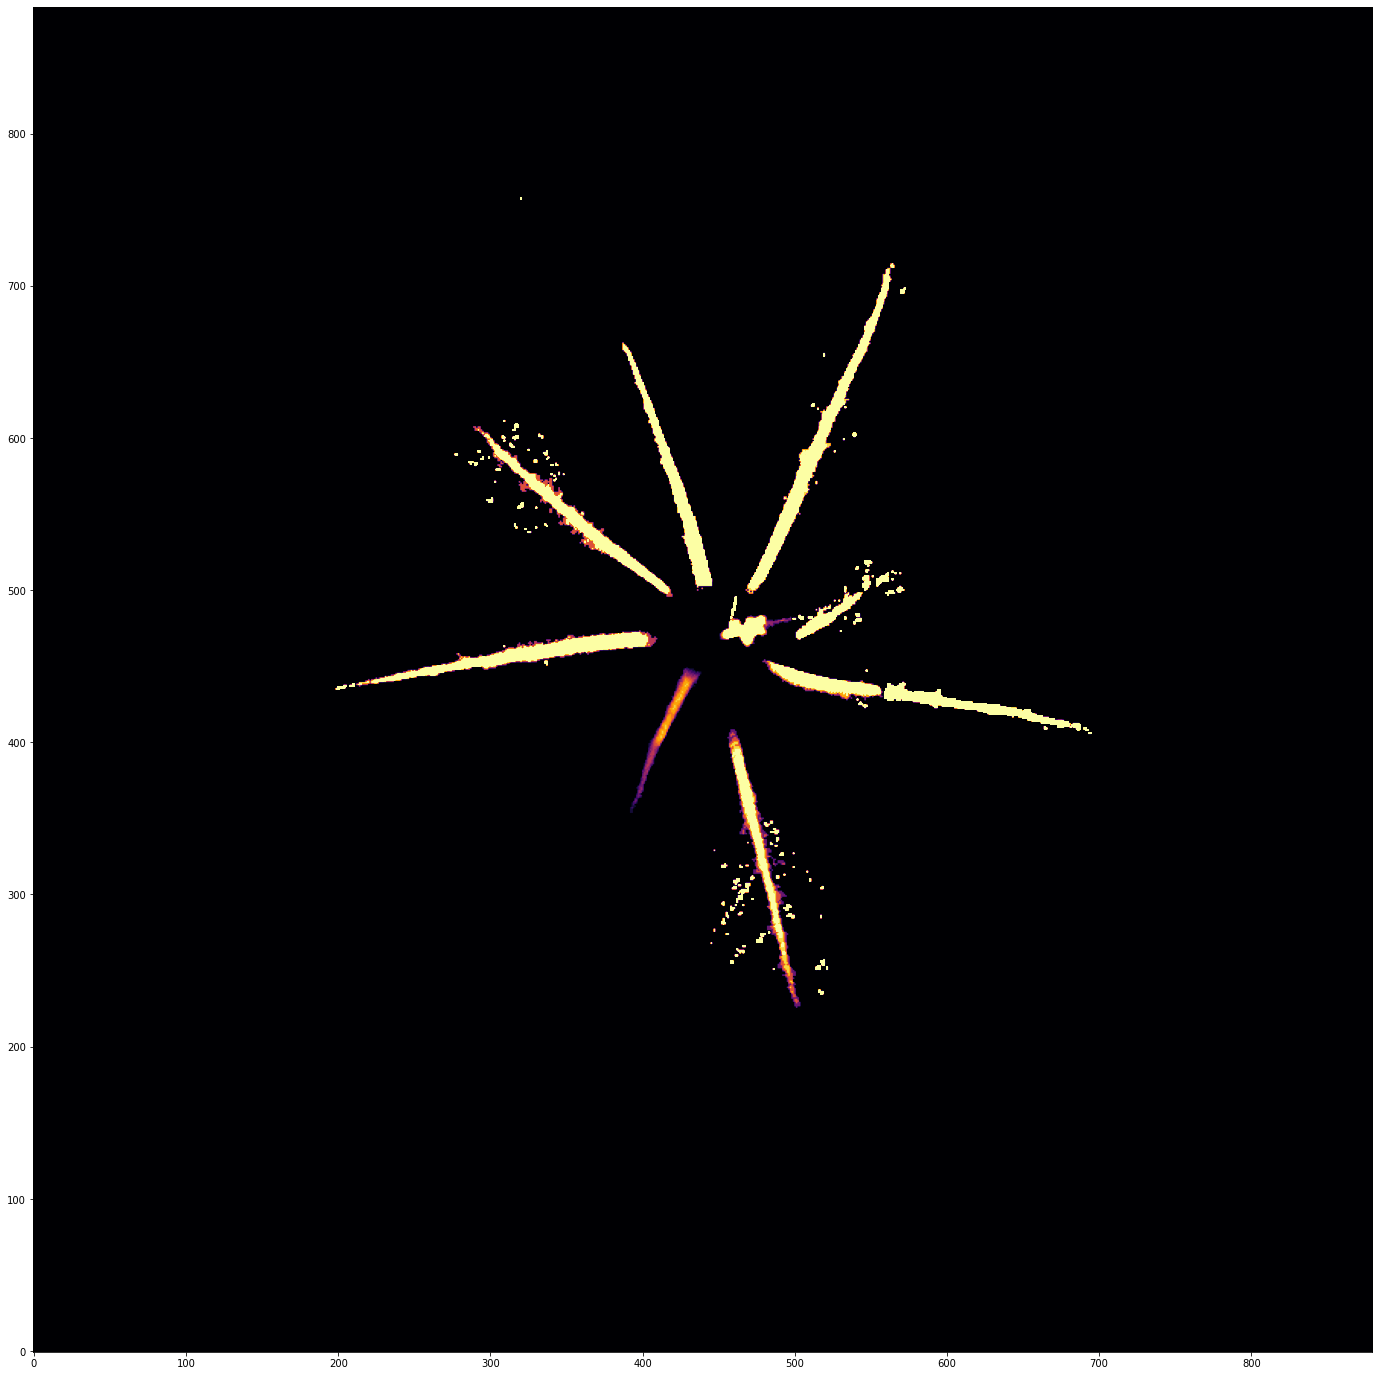

In [52]:
fig, ax = plt.subplots(figsize = (24,36))
im = ax.imshow(np.sum(markers_dict[1], axis = 0), cmap='inferno', origin='lower', vmax = 10)

plt.show()

In [44]:
from skimage.segmentation import watershed

In [45]:
watershed_test = watershed(pots_3d[0], markers_dict[0], connectivity=1, compactness=0)

In [46]:
fig, ax = plt.subplots(figsize = (24,36))
im = ax.imshow(watershed_test, axis = 0), cmap='inferno', origin='lower')

plt.show()

SyntaxError: invalid syntax (402889623.py, line 2)